In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import os

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 数据集类
class NPYDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        try:
            self.annotations = pd.read_csv(csv_file, encoding='utf-8')
        except UnicodeDecodeError:
            self.annotations = pd.read_csv(csv_file, encoding='gbk')
        self.root_dir = root_dir
        self.le = LabelEncoder()
        self.annotations['labels'] = self.annotations['labels'].apply(lambda x: x.strip("[]'"))
        self.annotations['labels'] = self.le.fit_transform(self.annotations['labels'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, str(self.annotations.iloc[index, -1]) + '.npy')
        image = np.load(img_name)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = self.annotations.iloc[index, 2]
        return image, label

# 模型定义
class ResNet2D(nn.Module):
    def __init__(self, num_classes=4):  # 默认值设为4，便于理解，实际上你可以根据需要传递任何数量
        super(ResNet2D, self).__init__()
        # 使用ResNet50作为基础模型
        self.resnet = models.resnet50(pretrained=True)
        # 冻结预训练模型的参数
        for param in self.resnet.parameters():
            param.requires_grad = False

        # 替换全连接层以适应新的分类任务
        num_ftrs = self.resnet.fc.in_features  # 获取全连接层的输入特征数
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)  # 替换全连接层，num_classes现在是4

    def forward(self, x):
        x = self.resnet(x)
        return x

# 之后的优化器、学习率调度器和训练循环可以保持不变

# 训练和评估参数
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据加载
train_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\train.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_train')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\test.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_test')
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

validation_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\validation.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_validation')
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
num_classes = len(np.unique(train_dataset.annotations['labels']))  # 这应该计算为4

# 创建一个权重数组
# 这里假设类别标签已经编码为0, 1
weights = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32).to(device)

# 使用加权损失函数
criterion = nn.CrossEntropyLoss(weight=weights)

model = ResNet2D(num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)  # 增加权重衰减

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练模型的代码...
# 请根据您的具体需求添加训练循环和验证/测试循环

C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
model_path = r'C:\Users\HP\Desktop\指南者\项目\眼病预测\trained_model.pth'  # 指定模型保存路径

In [66]:
# 正确的类别数，根据错误消息，应该是4
num_classes = 4

# 使用正确的类别数创建模型实例
model = ResNet2D(num_classes=num_classes)

# 现在加载模型应该不会出错，因为类别数匹配
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 根据你的需要调用 model.train() 或 model.eval()

C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [67]:
import torch  
import numpy as np  
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  
  
# 假设model, test_loader, device等都已正确定义和初始化  
  
model.eval()  
with torch.no_grad():  
    all_preds = []  
    all_labels = []  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device).long()  
        outputs = model(images)  
        _, predicted = torch.max(outputs.data, 1)  
          
        # 收集所有预测和标签  
        all_preds.extend(predicted.view(-1).cpu().numpy())  
        all_labels.extend(labels.view(-1).cpu().numpy())  
  
    # 计算准确率  
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)  
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')  
      
    # 计算精确率、召回率和F1分数  
    precision = precision_score(all_labels, all_preds, average='weighted')  
    recall = recall_score(all_labels, all_preds, average='weighted')  
    f1 = f1_score(all_labels, all_preds, average='weighted')  
      
    print(f'Precision: {precision:.4f}')  
    print(f'Recall: {recall:.4f}')  
    print(f'F1 Score: {f1:.4f}')  
  
    # 计算混淆矩阵  
    cm = confusion_matrix(all_labels, all_preds)  
      
    # 计算每个类别的准确率  
    class_accuracy = cm.diagonal() / cm.sum(axis=1)  
      
    # 打印每个类别的准确率  
    for i in range(len(class_accuracy)):  
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')  
  
# 打印所有预测结果（如果需要）  
# print('All Predictions:', all_preds)

Accuracy of the model on the test images: 90.27 %
Precision: 0.9146
Recall: 0.9027
F1 Score: 0.9039
Accuracy for class 0: 0.98
Accuracy for class 1: 0.77
Accuracy for class 2: 0.94
Accuracy for class 3: 0.92


In [30]:
# 打印所有预测结果
print('All Predictions:', all_preds)

All Predictions: [3, 3, 1, 2, 2, 3, 0, 0, 3, 1, 2, 3, 3, 3, 0, 0, 3, 0, 0, 2, 2, 1, 2, 3, 3, 1, 2, 0, 2, 0, 0, 0, 0, 2, 1, 3, 0, 2, 3, 3, 1, 2, 2, 1, 0, 1, 0, 1, 2, 2, 3, 3, 3, 3, 2, 1, 3, 3, 0, 3, 0, 2, 3, 2, 2, 0, 0, 0, 3, 2, 2, 3, 1, 3, 2, 2, 2, 3, 3, 0, 0, 2, 0, 1, 0, 0, 3, 3, 1, 0, 3, 1, 3, 0, 2, 0, 3, 2, 3, 0, 2, 3, 2, 1, 2, 3, 1, 2, 3, 0, 3, 2, 3, 1, 0, 2, 3, 2, 0, 0, 3, 3, 3, 2, 0, 1, 3, 0, 0, 0, 3, 3, 2, 2, 3, 0, 1, 1, 3, 2, 1, 0, 1, 0, 0, 3, 1, 2, 3, 1, 1, 3, 1, 0, 0, 3, 0, 0, 1, 2, 3, 0, 0, 3, 0, 0, 0, 2, 2, 2, 3, 0, 1, 1, 0, 0, 2, 2, 1, 1, 2, 3, 3, 0, 0, 0, 3, 3, 1, 1, 0, 2, 3, 3, 3, 3, 3, 1, 3, 0, 1, 2, 0, 3, 3, 3, 3, 0, 2, 0, 2, 0, 3, 3, 3, 0, 1, 0, 1, 0, 3, 2, 1, 1, 3, 3, 1, 0, 2, 1, 3, 0, 3, 1, 3, 1, 2, 1, 1, 0, 3, 3, 1, 1, 1, 3, 3, 0, 2, 1, 0, 3, 0, 0, 2, 0, 1, 3, 2, 0, 0, 3, 2, 3, 3, 1, 3, 0, 1, 0, 0, 1, 3, 1, 2, 0, 1, 0, 1, 0, 0, 3, 3, 3, 3, 1, 0, 1, 3, 1, 1, 2, 0, 3, 2, 2, 2, 0]


In [31]:
# Assuming `le` is your LabelEncoder instance that has been fitted to the labels
print("Label mapping:")
for i, label in enumerate(train_dataset.le.classes_):
    print(f"{label}: {i}")

Label mapping:
C: 0
D: 1
M: 2
N: 3


In [32]:
import torch  
import numpy as np  
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  
  
# 假设model, test_loader, device等都已正确定义和初始化  
  
model.eval()  
with torch.no_grad():  
    all_preds = []  
    all_labels = []  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device).long()  
        outputs = model(images)  
        _, predicted = torch.max(outputs.data, 1)  
          
        # 收集所有预测和标签  
        all_preds.extend(predicted.view(-1).cpu().numpy())  
        all_labels.extend(labels.view(-1).cpu().numpy())  
  
    # 计算准确率  
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)  
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')  
      
    # 计算精确率、召回率和F1分数  
    precision = precision_score(all_labels, all_preds, average='weighted')  
    recall = recall_score(all_labels, all_preds, average='weighted')  
    f1 = f1_score(all_labels, all_preds, average='weighted')  
      
    print(f'Precision: {precision:.4f}')  
    print(f'Recall: {recall:.4f}')  
    print(f'F1 Score: {f1:.4f}')  
  
    # 计算混淆矩阵  
    cm = confusion_matrix(all_labels, all_preds)  
      
    # 计算每个类别的准确率  
    class_accuracy = cm.diagonal() / cm.sum(axis=1)  
      
    # 打印每个类别的准确率  
    for i in range(len(class_accuracy)):  
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')  
  
# 打印所有预测结果（如果需要）  
# print('All Predictions:', all_preds)

Accuracy of the model on the test images: 90.27 %
Precision: 0.9146
Recall: 0.9027
F1 Score: 0.9039
Accuracy for class 0: 0.98
Accuracy for class 1: 0.77
Accuracy for class 2: 0.94
Accuracy for class 3: 0.92


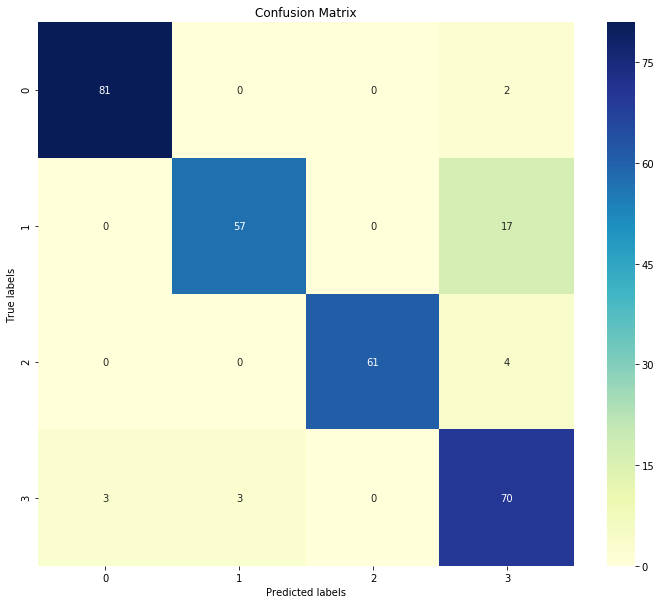

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 基于之前的预测结果计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(12, 10))  # 根据需要调整图像的大小
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(len(np.unique(all_labels))), yticklabels=range(len(np.unique(all_labels))))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [69]:
# 初始化一个空列表来存储预测错误的索引
error_indices = []

# 遍历所有预测和标签，比较它们是否相等
for idx, (pred, label) in enumerate(zip(all_preds, all_labels)):
    if pred != label:
        # 如果预测不等于标签，记录该实例的索引
        error_indices.append(idx)

# 输出预测错误的实例索引
print("预测错误的实例索引:", error_indices)

# 如果您想查看预测错误的详细信息，可以按以下方式打印每个错误实例的预测值和真实值
for error_index in error_indices:
    print(f'实例 {error_index} 错误预测为 {all_preds[error_index]}，实际标签为 {all_labels[error_index]}')

预测错误的实例索引: [13, 24, 38, 39, 44, 57, 71, 73, 108, 136, 152, 157, 181, 193, 195, 204, 205, 216, 220, 225, 232, 234, 246, 257, 263, 264, 272, 288, 297]
实例 13 错误预测为 3，实际标签为 2
实例 24 错误预测为 3，实际标签为 1
实例 38 错误预测为 3，实际标签为 1
实例 39 错误预测为 3，实际标签为 1
实例 44 错误预测为 0，实际标签为 3
实例 57 错误预测为 3，实际标签为 1
实例 71 错误预测为 3，实际标签为 1
实例 73 错误预测为 3，实际标签为 2
实例 108 错误预测为 3，实际标签为 0
实例 136 错误预测为 1，实际标签为 3
实例 152 错误预测为 1，实际标签为 3
实例 157 错误预测为 0，实际标签为 3
实例 181 错误预测为 3，实际标签为 2
实例 193 错误预测为 3，实际标签为 1
实例 195 错误预测为 3，实际标签为 1
实例 204 错误预测为 3，实际标签为 1
实例 205 错误预测为 3，实际标签为 1
实例 216 错误预测为 1，实际标签为 3
实例 220 错误预测为 3，实际标签为 1
实例 225 错误预测为 3，实际标签为 1
实例 232 错误预测为 3，实际标签为 1
实例 234 错误预测为 3，实际标签为 1
实例 246 错误预测为 3，实际标签为 0
实例 257 错误预测为 3，实际标签为 1
实例 263 错误预测为 3，实际标签为 2
实例 264 错误预测为 3，实际标签为 1
实例 272 错误预测为 3，实际标签为 1
实例 288 错误预测为 3，实际标签为 1
实例 297 错误预测为 0，实际标签为 3


In [36]:
import pandas as pd

# 给定的行号列表，已经转换为Python的索引（从0开始）
rows = [13, 24, 38, 39, 44, 57, 71, 73, 108, 136, 152, 157, 181, 193, 195, 204, 205, 216, 220, 225, 232, 234, 246, 257, 263, 264, 272, 288, 297]

# 读取CSV文件
df = pd.read_csv(r'C:\Users\HP\Desktop\指南者\项目\眼病预测\test.csv')

# 根据给定的行号提取filename列的值
selected_filenames = df.loc[rows, 'filename']

# 打印结果
print(selected_filenames)

13     5324
24     4979
38      249
39      443
44       52
57      403
71     5148
73      157
108    6230
136     475
152    4981
157    4961
181    4997
193     209
195    5370
204    5338
205    4982
216    5045
220     242
225      80
232    5185
234     491
246    5902
257    5421
263    5056
264    5337
272    5206
288     522
297    5309
Name: filename, dtype: int64


In [70]:
import os
import shutil
import pandas as pd

# 定义CSV文件的路径
csv_file_path = r'C:\Users\HP\Desktop\指南者\项目\眼病预测\double_test.csv'

# 使用Pandas读取CSV文件
try:
    df = pd.read_csv(csv_file_path)
    test_df = df
    print("CSV文件成功加载到DataFrame中。")
except FileNotFoundError:
    print(f"未找到文件：{csv_file_path}。请检查文件路径是否正确。")
except Exception as e:
    print(f"读取CSV文件时出错：{e}")

# 原始图像文件夹路径
source_folder = r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_test'

# 新的测试集图像文件夹路径
test_images_folder = r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_double_test_images'

# 创建新的文件夹（如果不存在）
os.makedirs(test_images_folder, exist_ok=True)

# 从DataFrame中提取测试集的图像文件名
test_filenames = test_df['filename'].tolist()

# 复制测试集图像到新的测试集文件夹
for filename in test_filenames:
    # 确保文件名是字符串类型，添加.npy扩展名（如果需要）
    filename_str = str(filename) + '.npy'  # 假设你需要添加.npy扩展名
    source_path = os.path.join(source_folder, filename_str)
    destination_path = os.path.join(test_images_folder, filename_str)
    # 检查源文件是否存在，再复制
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
    else:
        print(f"文件不存在：{source_path}")

print("图像已复制到相应的测试集文件夹。")

CSV文件成功加载到DataFrame中。
图像已复制到相应的测试集文件夹。


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import os

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 数据集类
class NPYDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        try:
            self.annotations = pd.read_csv(csv_file, encoding='utf-8')
        except UnicodeDecodeError:
            self.annotations = pd.read_csv(csv_file, encoding='gbk')
        self.root_dir = root_dir
        self.le = LabelEncoder()
        self.annotations['labels'] = self.annotations['labels'].apply(lambda x: x.strip("[]'"))
        self.annotations['labels'] = self.le.fit_transform(self.annotations['labels'])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, str(self.annotations.iloc[index, -1]) + '.npy')
        image = np.load(img_name)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = self.annotations.iloc[index, 2]
        return image, label

# 模型定义
class ResNet2D(nn.Module):
    def __init__(self, num_classes):
        super(ResNet2D, self).__init__()
        # 使用ResNet50作为基础模型
        self.resnet = models.resnet50(pretrained=True)
        # 冻结预训练模型的参数
        for param in self.resnet.parameters():
            param.requires_grad = False

        # 替换全连接层以适应新的分类任务
        num_ftrs = self.resnet.fc.in_features  # 获取全连接层的输入特征数
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)  # 替换全连接层

    def forward(self, x):
        x = self.resnet(x)
        return x

# 之后的优化器、学习率调度器和训练循环可以保持不变

# 训练和评估参数
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据加载
train_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\train.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_train')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\double_test.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_double_test_images')
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

validation_dataset = NPYDataset(csv_file=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\validation.csv', root_dir=r'C:\Users\HP\Desktop\指南者\项目\眼病预测\normalized_gaus_validation')
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
num_classes = len(np.unique(train_dataset.annotations['labels']))

# 创建一个权重数组
# 这里假设类别标签已经编码为0, 1
weights = torch.tensor([1.0, 1.0], dtype=torch.float32).to(device)

# 使用加权损失函数
criterion = nn.CrossEntropyLoss(weight=weights)

model = ResNet2D(num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)  # 增加权重衰减

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 训练模型的代码...
# 请根据您的具体需求添加训练循环和验证/测试循环

C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
model_path = r'C:\Users\HP\Desktop\指南者\项目\眼病预测\gaus_D_N classification\trained_model.pth'  # 指定模型保存路径

In [73]:
# 创建与之前相同的模型实例
# 请将num_classes替换为您实际使用的类别数
model = ResNet2D(num_classes=2)

# 加载保存的模型状态字典，确保映射到CPU
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 如果你要继续在训练模式下使用模型，别忘了调用 model.train()
# 如果是用于评估或预测，调用 model.eval()

C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\HP\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # 收集所有预测和标签
        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

    # 计算准确率
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')
    
    # 计算精确率、召回率和F1分数
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

Accuracy of the model on the test images: 97.96 %
Precision: 0.9797
Recall: 0.9796
F1 Score: 0.9796


In [75]:
from sklearn.metrics import roc_auc_score
# 计算AUC分数
auc_score = roc_auc_score(all_labels, all_preds)

print(f'AUC Score: {auc_score:.4f}')

AUC Score: 0.9795


In [76]:
# 打印所有预测结果
print('All Predictions:', all_preds)

All Predictions: [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]


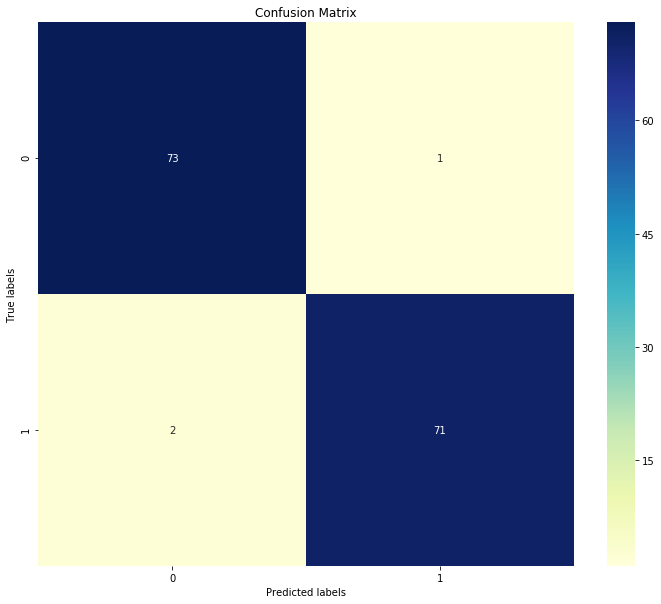

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 基于之前的预测结果计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 绘制混淆矩阵的热力图
plt.figure(figsize=(12, 10))  # 根据需要调整图像的大小
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(len(np.unique(all_labels))), yticklabels=range(len(np.unique(all_labels))))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [79]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 假设 all_preds 和 all_labels 已经被定义
# 例如:
all_preds = [0]*81 + [3]*2 + [1]*73 + [3]*1 + [2]*61 + [3]*4 + [0]*3 + [1]*2 + [3]*71
all_labels = [0]*83 + [1]*74 + [2]*65 + [3]*76

# 生成混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 打印混淆矩阵
print("混淆矩阵:")
print(cm)

混淆矩阵:
[[81  0  0  2]
 [ 0 73  0  1]
 [ 0  0 61  4]
 [ 3  2  0 71]]


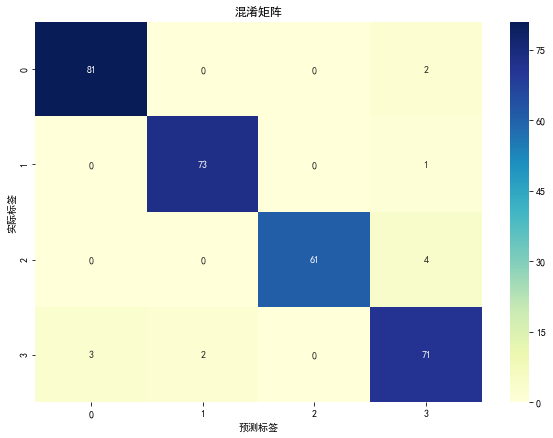

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib

# 配置matplotlib支持中文显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# 使用混淆矩阵的值作为示例
cm = np.array([
    [81, 0, 0, 2],
    [0, 73, 0, 1],
    [0, 0, 61, 4],
    [3, 2, 0, 71]
])

# 使用seaborn的heatmap函数绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")

# 添加轴标签和标题（现在可以使用中文了）
plt.ylabel('实际标签')
plt.xlabel('预测标签')
plt.title('混淆矩阵')

# 显示图形
plt.show()

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 假设 all_labels 和 all_preds 是你的真实标签和预测标签列表
# 例如:
all_labels = [0]*83 + [1]*74 + [2]*65 + [3]*76
all_preds = [0]*81 + [3]*2 + [1]*73 + [3]*1 + [2]*61 + [3]*4 + [0]*3 + [1]*2 + [3]*71

# 计算准确率
accuracy = accuracy_score(all_labels, all_preds)
print(f'准确率: {accuracy:.4f}')

# 计算精确率
precision = precision_score(all_labels, all_preds, average='macro')
print(f'精确率: {precision:.4f}')

# 计算召回率
recall = recall_score(all_labels, all_preds, average='macro')
print(f'召回率: {recall:.4f}')

# 计算F1分数
f1 = f1_score(all_labels, all_preds, average='macro')
print(f'F1分数: {f1:.4f}')

准确率: 0.9597
精确率: 0.9620
召回率: 0.9588
F1分数: 0.9601
